In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/sandstone_data_for_ML.zip", 'r')
zip_ref.extractall()
zip_ref.close()

Mounted at /content/drive/


# A short info on the Dataset

The images represent the XRM (tomography) scans of a sandstone cylinder of size about 2 mm 
diameter. The region around the sandstone that shows up as dark pixels in the image is air. Also, the 
dark regions inside the sandstone represents air/void. In addition to air, the region has 3 regions of 
interest that need to be segmented, quartz (light grey), clay (darker grey with texture), and pyrite (bright 
pixels). Clay and quartz are minority classes but since quartz appears in bright, it is easier to segment. 

# Why do petrologists care about segmenting these types of images?

 
Mineralogy is important to understand the value of a hydrocarbon reservoir. Lot of pore space is good 
as it potentially holds the hydrocarbons, quarts is good as it is brittle and easy to fracture, clay is bad as 
it does not fracture easily and also has potential to expand upon contact with water and clog the 
reservoir. 

In [ ]:
import tifffile as tif
import cv2
import glob2
import numpy as np

In [ ]:
images_dataset=tif.imread("/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif")

In [ ]:
images_dataset.shape

(1600, 128, 128)

In [ ]:
masks_dataset=tif.imread("/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif")

In [ ]:
masks_dataset.shape

(1600, 128, 128)

In [ ]:
# Lets get random images and masks to train and validate the model
random_generator=np.random.randint(masks_dataset.shape[0],size=500)

In [ ]:
random_train=random_generator[:350]

In [ ]:
random_val=random_generator[350:495]

In [ ]:
random_test=random_generator[495:]

In [ ]:
random_test.shape

(5,)

In [ ]:
images_train=images_dataset[random_train]
images_train=np.expand_dims(images_train,axis=3)
masks_train=masks_dataset[random_train]
print(images_train.shape)
print(masks_train.shape)

(350, 128, 128, 1)
(350, 128, 128)


In [ ]:
images_val=images_dataset[random_val]
images_val=np.expand_dims(images_val,axis=3)
masks_val=masks_dataset[random_val]
print(images_val.shape)
print(masks_val.shape)

(145, 128, 128, 1)
(145, 128, 128)


In [ ]:
images_test=images_dataset[random_test]
images_test=np.expand_dims(images_test,axis=3)
masks_test=masks_dataset[random_test]
print(images_test.shape)
print(masks_test.shape)

(5, 128, 128, 1)
(5, 128, 128)


### Now lets work on the masks

In [ ]:
# lets see the values of the masks to know the number of classes
print(np.unique(masks_train)) # this tells us that there are 4 different classes in the masks
n_class=len(np.unique(masks_train))

[1 2 3 4]


In [ ]:
masks_train.shape

(350, 128, 128)

#### Time for label encoding

In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
def mask_label_encoder(masks):
    labelencoder = LabelEncoder()
    n, h, w = masks.shape  
    masks = masks.reshape(-1,1)
    masks = labelencoder.fit_transform(masks)
    masks = masks.reshape(n, h, w)

    print(np.unique(masks))
    return masks

In [ ]:
temp=mask_label_encoder(masks_train);
temp.shape

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]


(350, 128, 128)

In [ ]:
# A check to see if the masks retruned with same structure
tem=temp[1]+1
if (tem==masks_train[1]).all():
  print("true")

true


In [ ]:
masks_train=mask_label_encoder(masks_train);
masks_val=mask_label_encoder(masks_val);
masks_test=mask_label_encoder(masks_test);

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


In [ ]:
# Now that we know that the data has 4 different classes 
# Then we need to create masks with 4 different channels , where evey channel corespondes to a different class
from tensorflow.keras.utils import to_categorical

masks_train = np.expand_dims(masks_train, axis = 3)
masks_val = np.expand_dims(masks_val, axis = 3)

masks_train = to_categorical(masks_train, num_classes=n_class)
masks_train = masks_train.reshape((masks_train.shape[0], masks_train.shape[1], masks_train.shape[2], n_class))

masks_val = to_categorical(masks_val, num_classes=n_class)
masks_val = masks_val.reshape((masks_val.shape[0], masks_val.shape[1], masks_val.shape[2], n_class))


In [ ]:
print(masks_train.shape)
masks_val.shape

(350, 128, 128, 4)


(145, 128, 128, 4)

# Now Lets start building our U net Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Lambda
from tensorflow.keras.models import Model

In [ ]:
def conv_block(layer,channels):
  layer=Conv2D(channels,3,activation='relu',padding='same')(layer)
  layer=BatchNormalization()(layer)
  layer=Conv2D(channels,3,activation='relu',padding='same')(layer)
  layer=BatchNormalization()(layer)
  return layer

In [ ]:
def encoder_block(layer,channels):
  layer_bef_max=conv_block(layer,channels)
  layer_aft_max=MaxPooling2D()(layer_bef_max)
  return layer_bef_max,layer_aft_max

In [ ]:
def decoder_block(layer,channels,skip_features):
  layer = Conv2DTranspose(channels, (2, 2), strides=2, padding="same")(layer)
  layer=concatenate([layer,skip_features])
  layer=conv_block(layer,channels)
  return layer

In [ ]:
def U_net_model(input_shape,num_class):
  input_img=Input(shape=(input_shape))

  # Encoder Block
  b1_layer,a1_layer=encoder_block(input_img,64)
  b2_layer,a2_layer=encoder_block(a1_layer,128)
  b3_layer,a3_layer=encoder_block(a2_layer,256)
  b4_layer,a4_layer=encoder_block(a3_layer,512)

  bridge=conv_block(a4_layer,1024)

  # Decoder Block
  d1=decoder_block(bridge,512,b4_layer)
  d2=decoder_block(d1,256,b3_layer)
  d3=decoder_block(d2,128,b2_layer)
  d4=decoder_block(d3,64,b1_layer)

  if num_class>=2:
    activation='softmax'
  else:
    activation='sigmoid'

  output = Conv2D(num_class, 1, padding="same", activation=activation)(d4)
  

  model=Model(input_img,output)

  return model

In [ ]:
input_shape=images_train[0].shape
print(input_shape)
model=U_net_model(input_shape,n_class)

(128, 128, 1)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history = model.fit(images_train, masks_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(images_val, masks_val), 
                    shuffle=False)

Epoch 1/50
22/22 [==============================] - 29s 724ms/step - loss: 0.5340 - accuracy: 0.8515 - val_loss: 19905.0137 - val_accuracy: 0.1235
Epoch 2/50
22/22 [==============================] - 6s 282ms/step - loss: 0.2036 - accuracy: 0.9499 - val_loss: 2311.4282 - val_accuracy: 0.0258
Epoch 3/50
22/22 [==============================] - 6s 282ms/step - loss: 0.1464 - accuracy: 0.9590 - val_loss: 993.5210 - val_accuracy: 0.0258
Epoch 4/50
22/22 [==============================] - 6s 275ms/step - loss: 0.1262 - accuracy: 0.9614 - val_loss: 47.2969 - val_accuracy: 0.0391
Epoch 5/50
22/22 [==============================] - 6s 271ms/step - loss: 0.1159 - accuracy: 0.9627 - val_loss: 7.9469 - val_accuracy: 0.1083
Epoch 6/50
22/22 [==============================] - 6s 268ms/step - loss: 0.1068 - accuracy: 0.9643 - val_loss: 2.1864 - val_accuracy: 0.4899
Epoch 7/50
22/22 [==============================] - 6s 266ms/step - loss: 0.1003 - accuracy: 0.9657 - val_loss: 0.7192 - val_accuracy: 0.

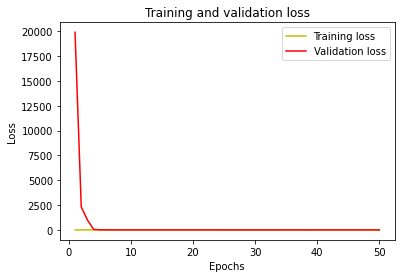

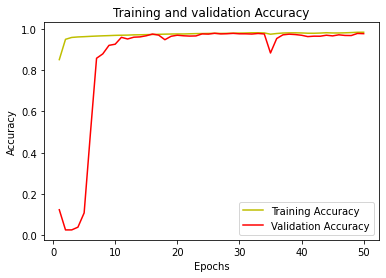

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Saving the model
model.save('/content/drive/MyDrive/U_net_Seg_weights')

In [ ]:
from keras.models import load_model
model_saved = load_model("/content/drive/MyDrive/U_net_Seg_weights")

In [ ]:
model_saved.summary()

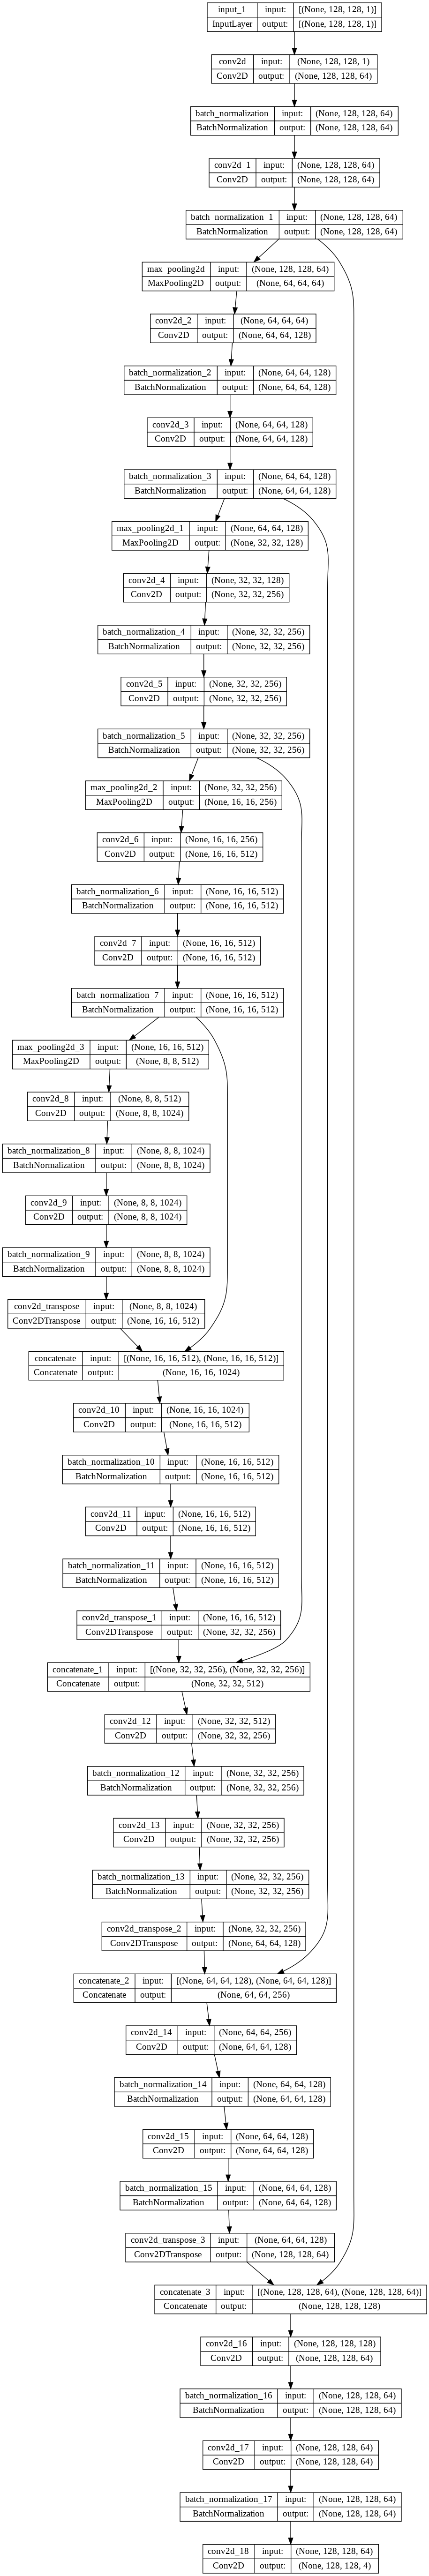

In [ ]:
tf.keras.utils.plot_model(model_saved, show_shapes=True)

1/1 [==============================] - 0s 19ms/step


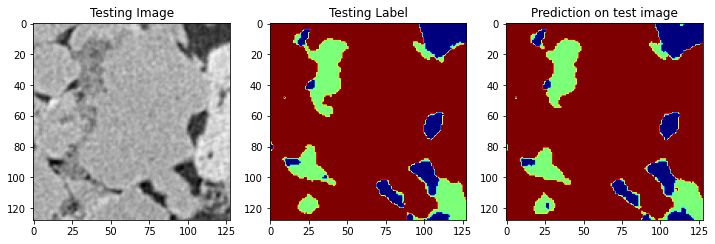

1/1 [==============================] - 0s 18ms/step


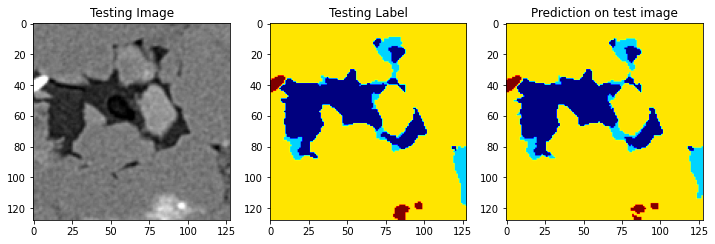

1/1 [==============================] - 0s 18ms/step


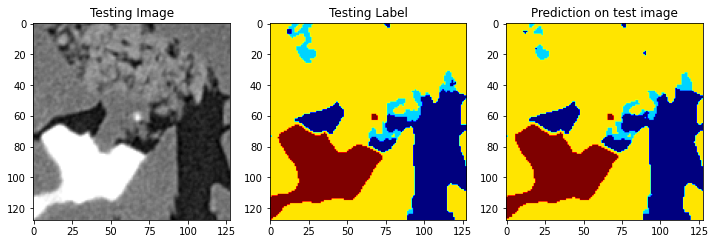

1/1 [==============================] - 0s 20ms/step


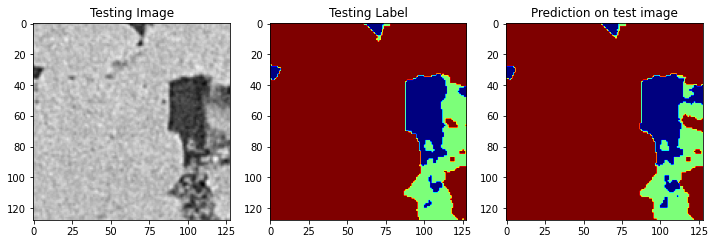

1/1 [==============================] - 0s 18ms/step


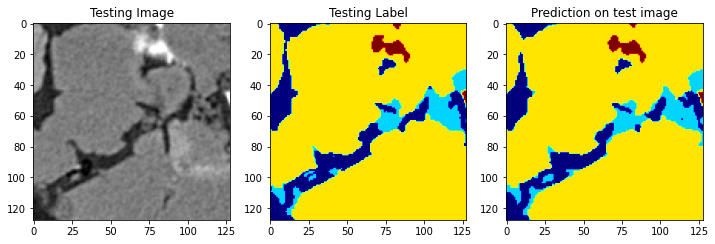

In [ ]:
import random
for i in range(len(images_test)):
  test_img = images_test[i]
  ground_truth=masks_test[i]
  test_img=np.expand_dims(test_img, 0)
  prediction = (model_saved.predict(test_img))
  predicted_img=np.argmax(prediction, axis=3)


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[0,:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:], cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img[0,:,:], cmap='jet')
  plt.show()